In [2]:
import sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.misc
from tqdm import tqdm

In [3]:
def r_t(D,z,t,x_1,y_1):
    mul = np.sqrt((D**2) - (z**2))
    x = x_1 + mul*np.cos(t)
    y = y_1 + mul*np.sin(t)
    r = np.sqrt((x**2) + (y**2) + (z**2))
    return r

class Uniform(object):
    @staticmethod
    def rho(r,p0,radius=1):
        if r > radius:
            return 0
        else:
            return p0
    
    @staticmethod
    def mass(D,x_1,y_1,p0,radius):
        def func(t,z):
            return Uniform.rho(r_t(D,z,t,x_1,y_1),p0,radius)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,radius=1,M=1):
        if D == 0:
            return 0
        p0 = M/((4/3) * np.pi * (radius**2))
        mass = Uniform.mass(D,x_1,y_1,p0,radius)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = Uniform.phi(x,ri,0,1,1,1) * step
        return out

class NFW(object):
    @staticmethod
    def rho(r,p0,Rs):
        if r > 3:
            return 0
        return p0 / ((r/Rs) * (1 + (r/Rs))**2)
    
    @staticmethod
    def mass(D,x_1,y_1,p0,Rs):
        def func(t,z):
            return NFW.rho(r_t(D,z,t,x_1,y_1),p0,Rs)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,c=5,Mvir=1):
        if D == 0:
            return 0
        Rs = 1/c
        p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
        mass = NFW.mass(D,x_1,y_1,p0,Rs)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri,c=5,Mvir=1):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = NFW.phi(x,ri,c=c,Mvir=Mvir) * step
        return out

def bin_phi(phis,dists,ri,r=1,nbins=50):
    bins = np.linspace(0,r + ri,nbins)
    start = bins[:-1]
    end = bins[1:]
    step = bins[1]-bins[0]
    xs = (end-start)/2 + start
    ys = []
    ahh = 0
    for idx in range(len(start)):
        temp_dists = dists[dists > start[idx]]
        temp_phis = phis[dists > start[idx]]
        temp_phis = temp_phis[temp_dists <= end[idx]]
        ahh += len(temp_phis)
        ys.append(np.sum(temp_phis))
    return xs,np.array(ys)

In [15]:
N = 10000000
df = sim.halos.Sample.NFW(N,c=5,Mvir=1,a=3)
ray = sim.utils.ray(np.array([1,0,0]),1,11)
raw_dists = sim.distances.cudaDist(ray,df,precision="f8")
mass = df.loc[:,"mass"][0]
G = 1
phis_f2 = sim.distances.listPhis(ray,df,precision="f2")
phis_f8 = sim.distances.listPhis(ray,df,precision="f8")
distances = sim.utils.points2radius(ray)

In [16]:
xs = []
first_ys = []
second_ys = []

idx = 0
for distance,phi_f2,phi_f8,dists in zip(distances,phis_f2,phis_f8,raw_dists):
    print(".",end="")
    xs_f2,ys_f2 = bin_phi(phi_f2,dists,distance)
    #xs_f8,ys_f8 = bin_phi(phi_f8,dists,distance)
    analytics_f8 = NFW.phis(xs_f2,distance,c=5,Mvir=1)
    #xs.append(xs_f8)
    xs.append(xs_f2)
    first_ys.append(ys_f2)
    second_ys.append(analytics_f8)

...........

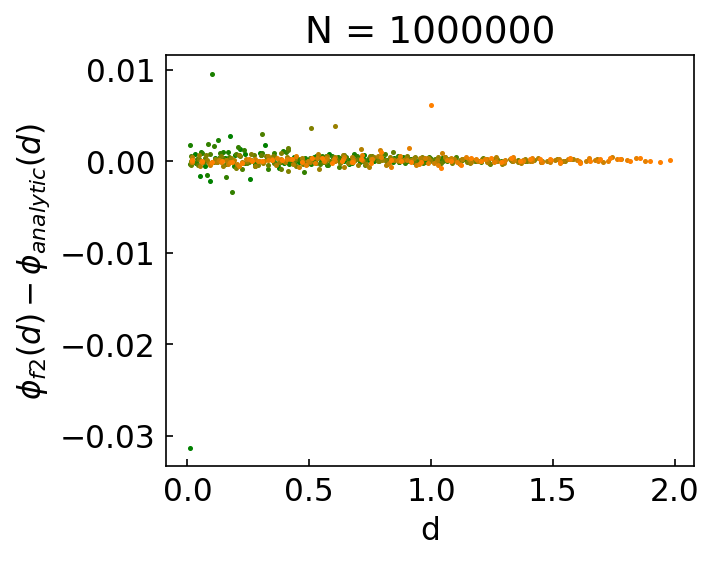

In [18]:
sim.pretty_plots.plot_pretty()
for distance,x,y1,y2 in zip(distances,xs,first_ys,second_ys):
    plt.scatter(x,np.array(y1)-np.array(y2),color=(distance,0.5,0),s=2)
plt.title("N = " + str(N))
plt.ylabel(r"$\phi_{f2}(d) - \phi_{analytic}(d)$")
plt.xlabel("d")
plt.tight_layout()
plt.savefig("f2_N_" + str(N) + ".jpg")
plt.show()